In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import scipy.signal as ss
import seaborn as sns
import numpy as np
from skimage.io import imread
from glob import glob
import os
import h5py

### Load Ben's processed data and apply filter
---
From the webpage and apply filter 514.
Download the following files from dm11\\\genie\BenArthur\GETI-screen
- summary-good-1AP.csv
- summary-good-10AP.csv
- summary-good-40AP.csv
- control-good-1AP.csv
- control-good-10AP.csv
- control-good-40AP.csv

In [2]:
sumPath = '/Volumes/genie/GENIE webpage/iGABASnFR2/FS screening'
savePath = '/Volumes/genie/Presentations/Jihong/GENIE production/220517'

In [3]:
stim = '10AP'
df_ben = pd.read_csv(sumPath+'/good_%s_220512.csv' %stim)
df_control_ben = pd.read_csv(sumPath+'/control_%s_220512.csv' %stim)

In [4]:
# df_ben
# df_ben.construct.unique()
# df_ben.shape
# df_ben.construct.unique().shape
# df_control_ben.columns
# df_control_ben
# df_control_ben.plate.unique()

In [5]:
df_plot = pd.DataFrame()
df_control_plot = pd.DataFrame()

In [6]:
df_plot['construct'] = df_ben['construct']
df_plot['no_pixels'] = df_ben['#pixels<sub>&nbsp;</sub>']
df_plot['thre'] = 1+(df_ben['ctrl pdi<sub>&nbsp;</sub>']/100.0)
df_plot['ctr_no_pixels'] = df_ben['ctrl #pix<sub>&nbsp;</sub>']

# Normalized data
df_plot['SNR'] = df_ben['SNR<sub></sub>']
df_plot['dFF'] = df_ben['&Delta;F/F<sub>0</sub>']
df_plot['F0'] = df_ben['F<sub>0</sub>']
df_plot['tau_on'] = df_ben['&tau;<sub>on</sub>']
df_plot['tau_off'] = df_ben['&tau;<sub>off</sub>']
df_plot['dFF_Tau_on_ratio'] = df_ben['&Delta;F/F<sub>0</sub>']/df_ben['&tau;<sub>on</sub>']

# # Unnormalized data
df_plot['SNR_unnorm'] = df_ben['unnormalized']
df_plot['dFF_unnorm'] = df_ben['unnormalized.1']
df_plot['F0_unnorm'] = df_ben['unnormalized.2']
df_plot['tau_on_unnorm'] = df_ben['unnormalized.3']
df_plot['tau_off_unnorm'] = df_ben['unnormalized.4']
df_plot['dFF_Tau_on_ratio_unnorm'] = df_ben['unnormalized.1']/df_ben['unnormalized.3']

# Control data
df_plot['ctr_SNR'] = df_ben['unnormalized']/df_ben['SNR<sub></sub>']
df_plot['ctr_dFF'] = df_ben['ctrl &Delta;F/F<sub>0</sub>']
df_plot['ctr_F0'] = df_ben['unnormalized.2']/df_ben['F<sub>0</sub>']
df_plot['ctr_tau_on'] = df_ben['unnormalized.3']/df_ben['&tau;<sub>on</sub>']
df_plot['ctr_tau_off'] = df_ben['unnormalized.4']/df_ben['&tau;<sub>off</sub>']
df_plot['ctr_dFF_Tau_on_ratio'] = df_ben['ctrl &Delta;F/F<sub>0</sub>']/df_ben['unnormalized.3']/df_ben['&tau;<sub>on</sub>']

# Control data (from df_control_ben, to plot both 514.1 and 514.4409)
df_control_plot['construct'] = df_control_ben['plate']
df_control_plot['no_pixels'] = df_control_ben['#pixels<sub>&nbsp;</sub>']
df_control_plot['SNR_unnorm'] = df_control_ben['SNR<sub></sub>']
df_control_plot['dFF_unnorm'] = df_control_ben['&Delta;F/F<sub>0</sub>']
df_control_plot['F0_unnorm'] = df_control_ben['F<sub>0</sub>']
df_control_plot['tau_on_unnorm'] = df_control_ben['&tau;<sub>on</sub>']
df_control_plot['tau_off_unnorm'] = df_control_ben['&tau;<sub>off</sub>']

df_plot['stim'] = stim


In [7]:
# pd.set_option('display.max_rows', df_plot.shape[0]+1)
# df_new.to_excel(r'C:\Users\zhengj10\Desktop\iGABASnFR_sreening_Nov_2021_variants.xlsx')
# df_new_control.to_excel(r'C:\Users\zhengj10\Desktop\iGABASnFR_sreening_Nov_2021_control.xlsx')

Filter data
- Drop constructs with N/A value
- Drop constructs with no. of pixels less than 10e3

In [8]:
df_plot = df_plot.dropna()
df_plot = df_plot[df_plot['construct'].str.contains('514.')] # Remove other GETIs like yGluSnFR
print(df_plot.shape)

df_control_plot = df_control_plot.dropna()
df_control_plot = df_control_plot[df_control_plot['construct'].str.contains('514.')] # Remove other GETIs
df_control_plot.shape

(6262, 23)


(433, 7)

In [9]:
C = []
for i,r in df_plot.iterrows():
    c = '514.'+r['construct'].split('514.')[1][:4]
    C.append(c)
df_plot['construct_id'] = C   

In [10]:
C = []
for i,r in df_control_plot.iterrows():
    C.append(r['construct'].split(' ')[0])
df_control_plot['construct_id'] = C

In [11]:
# df_control_plot
# df_plot

In [12]:
df_control_plot['construct_id'].unique().shape

(2,)

### Plot progress

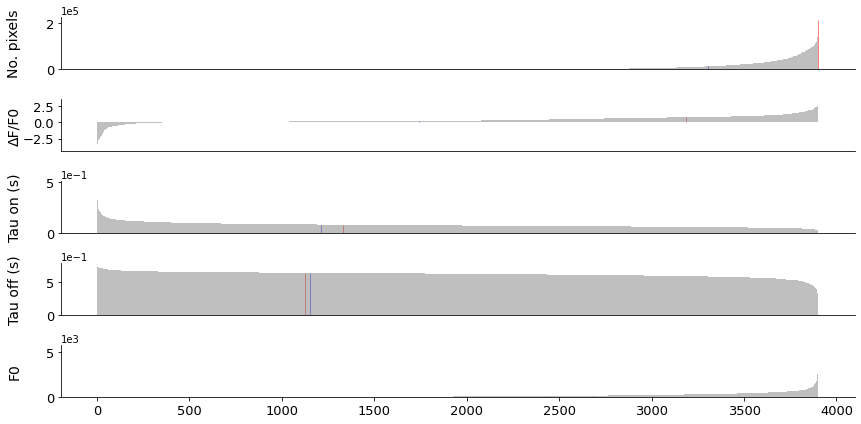

In [13]:
params = ['no_pixels','dFF_unnorm','tau_on_unnorm','tau_off_unnorm','F0_unnorm']
i=1
plt.figure(figsize=[12,6])
for param in params:
    Construct = []
    Val = []
    for c in df_plot.construct_id.unique():
        Construct.append(c)
        df_temp = df_plot[df_plot.construct_id==c]
        param_val = df_temp[param].median()
        Val.append(param_val)
        
    for c in df_control_plot.construct_id.unique():
        Construct.append(c)
        df_temp = df_control_plot[df_control_plot.construct_id==c]
        param_val = df_temp[param].median()
        Val.append(param_val)

    df_plot_sel = pd.DataFrame({'Construct':Construct,param:Val})
    if param in ['tau_on_unnorm','tau_off_unnorm']:
        df_plot_sel.sort_values(by=param,ascending=False,inplace=True)
    else:
        df_plot_sel.sort_values(by=param,ascending=True,inplace=True)
    df_plot_sel.index = np.arange(len(df_plot_sel))
    

    ax = plt.subplot(len(params),1,i)
    barlist = ax.bar(np.arange(len(df_plot_sel)),df_plot_sel[param],color='gray',width=1,alpha=0.5)

    barlist[df_plot_sel[df_plot_sel['Construct']=='514.1'].index[0]].set_color('b')
    barlist[df_plot_sel[df_plot_sel['Construct']=='514.4409'].index[0]].set_color('r')


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if i<5:
        plt.xticks([])
        
    if param == 'dFF_unnorm':
        ax.set_ylabel('\u0394F/F0',size=14)
    elif param == 'tau_on_unnorm':
        ax.set_ylabel('Tau on (s)',size=14)
    elif param == 'tau_off_unnorm':
        ax.set_ylabel('Tau off (s)',size=14)
    elif param == 'F0_unnorm':
        ax.set_ylabel('F0',size=14)
    elif param == 'no_pixels':
        ax.set_ylabel('No. pixels',size=14)
#         ax.set_ylim([0,10000])
        
    ax.get_yaxis().set_label_coords(-0.05,0.5)

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tick_params(labelsize=13)
    i+=1
plt.tight_layout()
plt.savefig(sumPath+'/screening_progress_%s.png' %stim, dpi=1200)
plt.savefig(savePath+'/screening_progress_%s.png' %stim, dpi=1200)
plt.show()

In [ ]:
# df_plot_sel[df_plot_sel['Construct']=='514.4409'].index[0]
# ax.get_xlim()[1]-14
# df_plot_sel[df_plot_sel['Construct']=='514.4409']
# df_plot_sel[df_plot_sel['Construct'].str.contains('4409')]
# df_plot_sel.style.set_properties(subset=['Construct'],**{'width':'490px'})
df_plot_sel

In [ ]:
# np.abs(df_plot['dFF'])
df_plot_sel

In [ ]:
df_plot_sel.shape

In [ ]:
# df_temp.shape

In [ ]:
# df_non = pd.DataFrame()
# for c in df_plot.construct.unique():
#     if c not in df_temp.construct.unique():
#         df_temp_2 = df_plot[df_plot['construct']==c]
#         df_non = pd.concat([df_non,df_temp_2])

In [ ]:
# df_non.shape

In [ ]:
# df_plot = df_plot[(df_plot['no_pixels']>10e3) & (df_plot['norm_fast_dFF']>10e-2)]
# df_plot = df_plot[df_plot['no_pixels']>10e3] # hurt 1AP data too much

- Plot top hits only (based on dFF or dFF/Tau_on)

In [ ]:
# df_plot = df_plot.sort_values(by=['dFF'],ascending=False)
# df_plot = df_plot.sort_values(by=['dFF_Tau_on_ratio'],ascending=False)
# df_plot.index = np.arange(len(df_plot))
# df_plot = df_plot.loc[0:14,:]

### Kerr plot (x: norm. dFF)
- Size of datapoints represents F0
- Constructs with norm. dFF > 1+PDI and norm. tau_on < 1.5 will be labeled

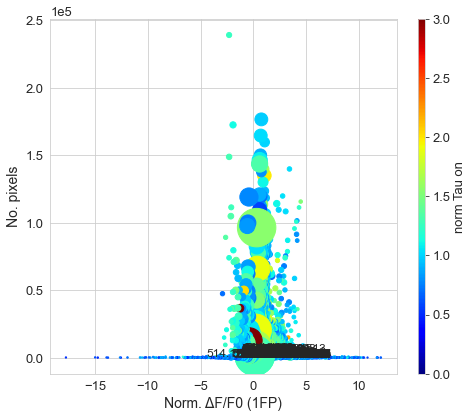

In [14]:
sns.set_style(style='whitegrid')
# fig = plt.figure(figsize=(7,6))
fig = plt.figure(figsize=(7,6))
plt.rc('font', size=13)
ax = plt.subplot(111)

all_sensors = plt.scatter(df_plot['dFF'],df_plot['no_pixels'],c=df_plot['tau_on'],s=df_plot['F0']*50, cmap="jet")
plt.clim(0, 3) # if using ax.scatter for above plot plt.clim will ask an image to be defined first
cbar = plt.colorbar(all_sensors,aspect=50)
# cbar.set_clim(-2.0, 2.0)

cbar.ax.set_ylabel('norm Tau on', rotation=90)

construct_l = df_plot.construct.to_list()
dFF_l = df_plot.dFF.to_list()
no_pixels_l = df_plot.no_pixels.to_list()
tau_on_l = df_plot.tau_on.to_list()
F0_l = df_plot.F0.to_list()

thre_l = df_plot.thre.to_list()

top_hits = []
top_hits_dFF = []
top_hits_no_pixels = []
top_hits_tau_on = []
top_hits_F0 = []

text_height = 125

for i,construct in enumerate(construct_l):
    if dFF_l[i]>5:
        continue
        
    if no_pixels_l[i]>5000:
        continue
#     if dFF_l[i]>3 and tau_on_l[i]<1.5:
    if dFF_l[i]>thre_l[i] and tau_on_l[i]<1:
#     if '633.4856' in construct or  '633.4092' in construct or '633.4404' in construct or '633.2642' in construct or '633.2388' in construct or '633.2392' in construct:
#     if '633.4856' in construct or  '633.4092' in construct or '633.4404' in construct:
        if ';' in construct:
            if construct.split(';')[0][-5]=='.':
                ax.text(dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-8:], ha="center",size=12)
                top_hits.append(construct.split(';')[0][-8:])
            else:
                ax.text(dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-7:], ha="center",size=12)
                top_hits.append(construct.split(';')[0][-7:])

            top_hits_dFF.append(dFF_l[i])
            top_hits_no_pixels.append(no_pixels_l[i])
            top_hits_tau_on.append(tau_on_l[i])
            top_hits_F0.append(F0_l[i])

        elif construct[-5]=='.':
            ax.text(dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct[-8:], ha="center",size=12)
            top_hits.append(construct[-8:])
            top_hits_dFF.append(dFF_l[i])
            top_hits_no_pixels.append(no_pixels_l[i])
            top_hits_tau_on.append(tau_on_l[i])
            top_hits_F0.append(F0_l[i])

        else:
            ax.text(dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct[-7:], ha="center",size=12)
    #             print(construct[-7:])
            top_hits.append(construct[-7:])
            top_hits_dFF.append(dFF_l[i])
            top_hits_no_pixels.append(no_pixels_l[i])
            top_hits_tau_on.append(tau_on_l[i])
            top_hits_F0.append(F0_l[i])
    
ax.set_xlabel('Norm. \u0394F/F0 (1FP)',size=14)
ax.set_ylabel('No. pixels',size=14)

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlim([-1, 5])
# ax.set_ylim([0, 5000])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
# fig.savefig(r'Z:\Presentations\Jihong\GENIE production\211124\iGABASnFR_FS_211110_by_dFF_10AP.png',dpi=1200)
# fig.savefig(r'C:\Users\zhengj10\Desktop\iGluSnFR_FS_1AP_top_15_hits_by_dFF.png',dpi=1200)
# fig.savefig(sumPath+'\\Kerr_1AP.png',dpi=1200)
plt.show()


In [ ]:
(ax.get_ylim()[0]+ax.get_ylim()[1])/40
# ax.get_ylim()

In [ ]:
# df_plot[df_plot.construct.str.contains('514.')]

### Kerr plot (x: norm. dFF/tau_on)
- Size of datapoints represents F0
- Constructs with norm. dFF > 1+PDI and norm. tau_on < 1.5 will be labeled

In [ ]:
# df_plot

In [ ]:
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=(7,6))
plt.rc('font', size=13)
ax = plt.subplot(111)

all_sensors = plt.scatter(df_plot['dFF_Tau_on_ratio'],df_plot['no_pixels'],c=df_plot['tau_on'],s=df_plot['F0']*50, cmap="jet")
plt.clim(0, 3) # if using ax.scatter for above plot plt.clim will ask an image to be defined first
cbar = plt.colorbar(all_sensors,aspect=50)
# cbar.set_clim(-2.0, 2.0)

cbar.ax.set_ylabel('norm Tau on', rotation=90)

construct_l = df_plot.construct.to_list()
dFF_l = df_plot.dFF.to_list()
dFF_Tau_on_ratio_l = df_plot.dFF_Tau_on_ratio.to_list()
no_pixels_l = df_plot.no_pixels.to_list()
tau_on_l = df_plot.tau_on.to_list()
F0_l = df_plot.F0.to_list()
ctr_dFF_Tau_on_ratio_l = df_plot.ctr_dFF_Tau_on_ratio.to_list()
thre_l = df_plot.thre.to_list()


text_height = 124

for i,construct in enumerate(construct_l):
    if dFF_l[i]>4:
        continue
    if dFF_Tau_on_ratio_l[i]>2.5:

        if ';' in construct:
            if construct.split(';')[0][-5]=='.':
                ax.text(dFF_Tau_on_ratio_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-8:], ha="center",size=12)
            else:
                ax.text(dFF_Tau_on_ratio_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-7:], ha="center",size=12)


        elif construct[-5]=='.':
            ax.text(dFF_Tau_on_ratio_l[i],no_pixels_l[i]+text_height, "%s" %construct[-8:], ha="center",size=12)


        else:
            ax.text(dFF_Tau_on_ratio_l[i],no_pixels_l[i]+text_height, "%s" %construct[-7:], ha="center",size=12)
#             print(construct[-7:])

    
ax.set_xlabel('Norm. \u0394F/F0/Tau_on (10FP)',size=14)
ax.set_ylabel('No. pixels',size=14)

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlim([-0.2,4])
ax.set_ylim([-0.05,5000])

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
# fig.savefig(r'Z:\Presentations\Jihong\GENIE production\211124\iGABASnFR_FS_211110_by_dFF_tau_on_ratio_10AP.png',dpi=1200)
# fig.savefig(r'C:\Users\zhengj10\Desktop\iGluSnFR_FS_1AP_top_15_hits_by_dFF_Tau_on_ratio.png',dpi=1200)
# fig.savefig(sumPath+'\\Kerr_1AP.png',dpi=1200)
plt.show()


In [ ]:
pd.set_option('display.max_columns', df_plot.shape[1]+1)
# df_plot[df_plot.construct.str.contains('633.543')]

In [ ]:
(ax.get_ylim()[0]+ax.get_ylim()[1])/40
# df_ben[df_ben['construct'].str.contains('4404')]

### Kerr plot (x: norm. fast dFF)
- Size of datapoints represents F0
- Constructs with norm. dFF > 1+PDI and norm. tau_on < 1.5 will be labeled

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=(15,10))
plt.rc('font', size=15)
ax = plt.subplot(111)

all_sensors = plt.scatter(df_plot['fast_dFF'],df_plot['no_pixels'],c=df_plot['tau_on'],s=df_plot['F0']*50, cmap="jet")
plt.clim([0,2])
cbar = plt.colorbar(all_sensors,aspect=50)
cbar.ax.set_ylabel('norm. Tau on', rotation=90)

construct_l = df_plot.construct.to_list()
no_pixels_l = df_plot.no_pixels.to_list()
fast_dFF_l = df_plot.fast_dFF.to_list()
top_hits_fast_dFF = []

for i,construct in enumerate(construct_l):
    if fast_dFF_l[i]>thre_l[i]:
#     if '633.4856' in construct or  '633.4092' in construct or '633.4404' in construct or '633.2642' in construct or '633.2388' in construct or '633.2392' in construct:
#     if '633.4856' in construct or  '633.4092' in construct or '633.4404' in construct:
        if ';' in construct:
            if construct.split(';')[0][-5]=='.':
                ax.text(fast_dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-8:], ha="center",size=15)
                top_hits_fast_dFF.append(construct.split(';')[0][-8:])
            else:
                ax.text(fast_dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-7:], ha="center",size=15)
                top_hits_fast_dFF.append(construct.split(';')[0][-7:])

            top_hits_fast_dFF.append(dFF_l[i])

        elif construct[-5]=='.':
            ax.text(fast_dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct[-8:], ha="center",size=15)
            top_hits_fast_dFF.append(construct[-8:])

        else:
            ax.text(fast_dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct[-7:], ha="center",size=15)
    #             print(construct[-7:])
            top_hits_fast_dFF.append(construct[-7:])

ax.set_xlabel('Norm. fast \u0394F/F0',size=18)
ax.set_ylabel('No. pixels',size=18)
# ax.set_xlim([0,5])

# ax.set_yscale('log')
# ax.set_xscale('log')

plt.tight_layout()
# fig.savefig(r'Y:\Presentation\210831\210713-210817-1AP_norm_fast_dF_20AP.png',dpi=1200)
# fig.savefig(r'Y:\Presentation\210825\210713-210817-1AP_norm_fast_dFF_20AP.pdf',format='pdf')
plt.show()

### Kerr plot (unnormalized)
- Size of datapoints represents F0
- Constructs with dFF_unnorm > max of control will be labeled

In [ ]:
# df_plot.columns
df_control_plot.columns

In [ ]:
df_control_plot_sel = df_control_plot[df_control_plot.construct.str.contains('514.4409')]
mean = (df_control_plot_sel['dFF']/df_control_plot_sel['tau_on']).mean()
mean_pdi = np.nanmean(df_control_ben['pdi<sub>&nbsp;</sub>'].to_list())
thre = mean*(1+mean_pdi/100)
# thre = mean


sns.set_style(style='whitegrid')
fig = plt.figure(figsize=(8,6.5))
plt.rc('font', size=15)
ax = plt.subplot(111)

all_sensors = plt.scatter(df_plot['dFF_unnorm'],df_plot['no_pixels'],c=df_plot['tau_on_unnorm']*1000,
                          s=df_plot['F0_unnorm']*2, cmap="jet")
# plt.clim(0,150)
cbar_1 = plt.colorbar(all_sensors,aspect=50)
cbar_1.ax.set_ylabel('Tau on (ms)',rotation=90)

df_control_plot_sel = df_control_plot[df_control_plot.construct.str.contains('514.1')]
ctr_A = plt.scatter(df_control_plot_sel['dFF'],df_control_plot_sel['no_pixels'],c=df_control_plot_sel['tau_on']*1000,
                    s=df_control_plot_sel['F0']*2,marker='x',cmap="jet")
# plt.clim(0,150)
# cbar_2 = plt.colorbar(ctr_A,aspect=50,pad=-0.03)
# cbar_2.ax.set_ylabel('Control (514.1) tau on (ms)',rotation=90)

df_control_plot_sel = df_control_plot[df_control_plot.construct.str.contains('514.4409')]
ctr_B = plt.scatter(df_control_plot_sel['dFF'],df_control_plot_sel['no_pixels'],c=df_control_plot_sel['tau_on']*1000,
                    s=df_control_plot_sel['F0']*2,marker='s',cmap="jet")
# plt.clim(0,150)
# cbar_3 = plt.colorbar(ctr_B,aspect=50)
# cbar_3.ax.set_ylabel('Control (514.4409) tau on (ms)',rotation=90)

import matplotlib.lines as mlines
cross = mlines.Line2D([], [], color='gray', marker='x', linestyle='None',
                          markersize=10, label='514.1')
square = mlines.Line2D([], [], color='gray', marker='s', linestyle='None',
                          markersize=10, label='514.4409')
circle = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                          markersize=10, label='Variants')

plt.legend(handles=[cross, square, circle])


construct_l = df_plot.construct.to_list()
dFF_Tau_on_ratio_l = df_plot.dFF_Tau_on_ratio_unnorm.to_list()
no_pixels_l = df_plot.no_pixels.to_list()
dFF_unnorm_l = df_plot.dFF_unnorm.to_list()
tau_on_unnorm_l = df_plot.tau_on_unnorm.to_list()
top_hits_dFF_unnorm = []

text_height = 16087.410175937068

for i,construct in enumerate(construct_l):
#     if dFF_unnorm_l[i]<0 or no_pixels_l[i]<1000:
#         continue
    if no_pixels_l[i]>10000:
#         if dFF_Tau_on_ratio_l[i]>thre and no_pixels_l[i]>100:
        if ';' in construct:
            if construct.split(';')[0][-5]=='.':
                ax.text(dFF_unnorm_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-8:], ha="center",size=15)
                top_hits_dFF_unnorm.append(construct.split(';')[0][-8:])
                print(construct[-8:])
            else:
                ax.text(dFF_unnorm_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-7:], ha="center",size=15)
                top_hits_dFF_unnorm.append(construct.split(';')[0][-7:])
                print(construct[-8:])

#             top_hits_dFF_unnorm.append(dFF_l[i])

        elif construct[-5]=='.':
            ax.text(dFF_unnorm_l[i],no_pixels_l[i]*1.2, "%s" %construct[-8:], ha="center",size=15)
            top_hits_dFF_unnorm.append(construct[-8:])
            print(construct[-8:])

        else:

            ax.text(dFF_unnorm_l[i],no_pixels_l[i]+text_height, "%s" %construct[-7:], ha="center",size=15)
    #             print(construct[-7:])
            top_hits_dFF_unnorm.append(construct[-7:])
            print(construct[-7:])

#     ax.text(dFF_unnorm_l[i],no_pixels_l[i]*1.2, "%s" %construct[-8:], ha="center",size=15)
#     top_hits_dFF_unnorm.append(construct[-8:])

ax.set_xlabel('\u0394F/F0',size=14)
ax.set_ylabel('No. pixels',size=14)

# ax.set_xlim([0,2.5])
# ax.set_ylim([100,421754.61728867824])
ax.set_yscale('log')
# ax.set_xscale('log')


plt.tight_layout()
# fig.savefig(r'Z:\Presentations\Jihong\GENIE production\211201\iGABASnFR_nov_unnorm_40AP_kerr.png',dpi=1200)
# fig.savefig(r'C:\Users\zhengj10\Desktop\iGABASnFR_nov_unnorm_%s_kerr.png' %stim,dpi=1200)
# fig.savefig(r'Y:\Presentation\210831\210713-210817-1AP_norm_fast_dF_20AP.png',dpi=1200)
# fig.savefig(r'Y:\Presentation\210825\210713-210817-1AP_norm_fast_dFF_20AP.pdf',format='pdf')
plt.show()


In [ ]:
df_sort = df_plot.sort_values(by='F0',ascending=False)
# for i,r in df_sort.iterrows():
#     print(r['construct'].split('.')[-1])
# df_sort  


In [ ]:
df_control_plot_sel
(ax.get_ylim()[1]-ax.get_ylim()[0])/40

In [ ]:
# thre

## Top hits based on dFF/Tau on (1FP data)
# 514.4630
# 514.4276
# 514.4622
# 514.4640
# 514.4629
# 514.4534
# 514.4478
# 514.4479


In [ ]:
df_ben[df_ben.construct.str.contains('514.4622')]


In [ ]:
plt.scatter?

In [ ]:
# df_plot['ctr_dFF'].max()*0.75
# df_plot.construct.unique()
# ax.get_ylim()
# ax.get_xlim()
# np.log(no_pixels_l[i])

In [ ]:
# (ax.get_ylim()[0]+ax.get_ylim()[1])/40

In [ ]:
# df_plot.columns
# df_plot['ctr_dFF'].max()
# '633.4404' in top_hits_dFF_unnorm
# construct_l
inset_axes?

### Plot individual top hits dFF from .mat file in Ben's processed data

In [ ]:
dataPath = r'Z:\BenArthur\GETI-screen'

In [ ]:
kw = '4409'
df_control_sel = df_control_plot[df_control_plot.construct.str.contains(kw)]
df_control_sel.index = np.arange(len(df_control_sel))
pd.set_option('display.max_columns', df_control_sel.shape[1]+1)
df_control_sel

In [ ]:
date = df_control_sel['transfect/plate'][0].split('/')[0]
plate = df_control_sel['transfect/plate'][0].split('/')[1]
matFiles = glob(os.path.join(dataPath,date,plate)+'\\*.mat')

In [ ]:
kw = '4623'
df_ben_sel = df_ben[df_ben.construct.str.contains(kw)]
df_ben_sel.index = np.arange(len(df_ben_sel))
pd.set_option('display.max_columns', df_ben_sel.shape[1]+1)
df_ben_sel

In [ ]:
date = df_ben_sel['transfect/plate'][0].split('/')[0]
plate = df_ben_sel['transfect/plate'][0].split('/')[1]
matFiles = glob(os.path.join(dataPath,date,plate)+'\\*.mat')

In [ ]:
matFiles_sel = [m for m in matFiles if kw in m]
matFiles_sel = sorted(matFiles_sel)

In [ ]:
matFiles_sel

In [ ]:
freq = '1AP'
matFiles_freq = [m for m in matFiles_sel if freq in m]
matFiles_freq

In [ ]:
df_ben_sel['transfect/plate']
# date

In [ ]:
for matFile in matFiles_freq:
    matData = h5py.File(matFile,'r')
    dFF_trace = matData['responsive_traces']['fit']['bleach_bkg_norm_ave_filt_trace'][()]
    plt.plot(dFF_trace)

### Select top hits
---
Pick up top 100 hits with greatest dFF/tau_on

In [ ]:
df_plot = df_plot.assign(dFF_Tau_on_ratio = df_plot.dFF/df_plot.tau_on)

In [ ]:
df_plot_sorted_by_ratio = df_plot.sort_values(by = 'dFF_Tau_on_ratio',ascending = False)

In [ ]:
df_plot_sorted_by_ratio.index = np.arange(len(df_plot_sorted_by_ratio))

In [ ]:
df_plot_sorted_by_ratio.loc[:99,['construct','dFF','dFF_Tau_on_ratio']].to_excel(r'C:\Users\zhengj10\Desktop\100_greatest_dFF_Tau_on_ratio_2.xlsx')

Selection top 10 constructs with smallest tau_on

In [ ]:
df_plot_sorted_by_tau_on = df_plot.sort_values(by = 'tau_on',ascending = True)

In [ ]:
df_plot_sorted_by_tau_on.index = np.arange(len(df_plot_sorted_by_tau_on))

In [ ]:
df_plot_sorted_by_tau_on

Selection top 10 constructs with greatest dFF

In [ ]:
df_plot_sorted_by_dFF = df_plot.sort_values(by = 'dFF',ascending = False)

In [ ]:
df_plot_sorted_by_dFF.index = np.arange(len(df_plot_sorted_by_dFF))


In [ ]:
df_plot_sorted_by_dFF[df_plot_sorted_by_dFF.construct.str.contains('2185')]

Check if the smallest tau_on constructs are within the 100 constructs with greatest dFF/tau_on

In [ ]:
for i,r in df_plot_sorted_by_tau_on.loc[:9,:].iterrows():
    if r['construct'] in df_plot_sorted_by_ratio.loc[:99,:].construct.to_list():
        print(r['construct'])

Check if the smallest tau_on constructs are within the 100 constructs with greatest dFF/tau_on

In [ ]:
for i,r in df_plot_sorted_by_dFF.loc[:9,:].iterrows():
    if r['construct'] in df_plot_sorted_by_ratio.loc[:99,:].construct.to_list():
        pass
#         print('In top 100 largest dFF/Tau_on')
#         print(r['construct'])
    else:
#         print('Not in top 100 largest dFF/Tau_on:')
        print(' ' + r['construct'])
        